In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path


In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_platforms", 'cpu')
import jax.numpy as jnp

In [3]:
# Load the MNIST results
results = []
paths = ['../results/mnist_results/mlp/dlrg-l-ef-bong-R10_nlls_0.1.pkl',
         '../results/mnist_results/mlp/dlrg-l-ef-bong-R10_nlls_0.01.pkl',
         '../results/mnist_results/mlp/dlrg-l-ef-bong-R10_nlls_1.0.pkl',
         '../results/mnist_results/mlp/dlrg-l-ef-bong-R10_nlls_10.0.pkl']
for path in paths:
    with open(path, 'rb') as f:
        results.append(pickle.load(f))

results = np.concatenate(results, axis=0)
results.shape

(40, 2000, 2000)

In [4]:
results.shape, type(results)

((40, 2000, 2000), numpy.ndarray)

In [5]:
jax.vmap(lambda x: jnp.diag(x, k=1))(results).shape

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/export/home/dwaxman/.local/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 610, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/lib/python3/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 97, in initialize
    xla_client.register_custom_type_id_handler(
AttributeError: module 'jaxlib.xla_client' has no attribute 'register_custom_type_id_handler'


(40, 1999)

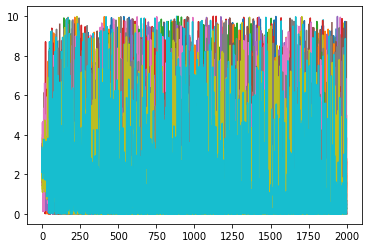

In [6]:
plt.plot(jax.vmap(lambda x: jnp.diag(x, k=1))(results).T)

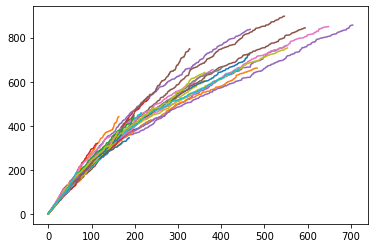

In [7]:
plt.plot(jax.numpy.cumsum(jax.vmap(lambda x: jnp.diag(x, k=1))(results).T, axis=0))

In [8]:
jax.numpy.cumsum(jax.vmap(lambda x: jnp.diag(x, k=1))(results).T, axis=0).shape

(1999, 40)

In [9]:
#%%
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import lax, jit, value_and_grad
from functools import partial
import optax 
import numpy as np
from jax.scipy.special import logsumexp
from scipy.stats import norm

import argparse

import cvxopt
from cvxopt import matrix, solvers
cvxopt.solvers.options['show_progress'] = False


compute_ons = 1
N = 999

#%% Auxiliary functions
def get_weights_expgrad(alpha,pll_t):
    def _step_weights(carry, i):
            log_w = carry

            li = jnp.asarray(pll_t)[:,i-1]

            # Exponentiated Gradients
            log_w = log_w + alpha * jnp.exp(
                li - jax.scipy.special.logsumexp(log_w + li)
            )
            log_w = log_w - jax.scipy.special.logsumexp(log_w)

            return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0])/pll_t.shape[0])
    w = jnp.exp(logw)    
    final_log_w, log_ws = lax.scan(
            _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
        )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)  # we don't consider the last weight

    return log_ws


def get_weights_expgrad_bma(alpha,pll_t):
    def _step_weights(carry, i):
            log_w = carry

            li = jnp.asarray(pll_t)[:,i-1]

            # Exponentiated Gradients
            log_w = log_w + alpha * li
            log_w = log_w - jax.scipy.special.logsumexp(log_w)

            return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0])/pll_t.shape[0])
    w = jnp.exp(logw)    
    final_log_w, log_ws = lax.scan(
            _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
        )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws


def get_weights_softbayes(alpha, pll_t):
    def _step_weights(carry, i):
            log_w = carry

            li = jnp.asarray(pll_t)[:,i-1]
            M_t = logsumexp(log_w + li)

            # Soft-Bayes
            log_w = log_w + logsumexp(jnp.array([jnp.log1p(-alpha), jnp.log(alpha) + (li - M_t)]))

            return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0])/pll_t.shape[0])
    w = jnp.exp(logw)    
    final_log_w, log_ws = lax.scan(
            _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
        )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws

def get_weights_corrected_softbayes(M, pll_t):
    log_M = jnp.log(M)

    def _step_weights(carry, i):
            alpha_t = jnp.sqrt(log_M / (2 * M * (i)))
            alpha_tp1 = jnp.sqrt(log_M / (2 * M * (i+1)))

            log_w = carry

            li = jnp.asarray(pll_t)[:,i-1]
            M_t = logsumexp(log_w + li)

            # Soft-Bayes
            A = log_w 
            B = jnp.log(1 - alpha_t + alpha_t * jnp.exp(li - M_t))# logsumexp(jnp.array([jnp.log1p(-alpha_t) * jnp.ones(pll_t.shape[0]), jnp.log(alpha_t) + (li - M_t)]))
            C = jnp.log(alpha_tp1 / alpha_t) * jnp.ones(pll_t.shape[0])
            D = jnp.log(1 - alpha_tp1 / alpha_t) + jnp.ones(pll_t.shape[0]) * jnp.log(1/M)
            # print(A.shape, B.shape, C.shape, D.shape)
            # print((A + B + C).shape)
            # print(D.shape)
            log_w = logsumexp(jnp.array([A + B + C, D]), axis=0)   
            # print(carry.shape, log_w.shape)

            return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0])/pll_t.shape[0])
    w = jnp.exp(logw)    
    final_log_w, log_ws = lax.scan(
            _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
        )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws

def get_static_weights(pll_t): # best constant rebalanced portfolio (BCRP)

    def neg_log_wealth(log_weights,pll_t):   # log_weights are not normalized!
        log_mix = logsumexp(log_weights + pll_t.T - logsumexp(log_weights),axis=1)

        return -jnp.sum(log_mix)
    
    neg_log_wealth_jit = jit(neg_log_wealth)

    init_params = jnp.log(jnp.ones(pll_t.shape[0]) \
                        + 0.3*jax.random.normal(jax.random.PRNGKey(my_seed+20),(pll_t.shape[0],))
                        )


    # Define the optimizer
    optimizer = optax.adam(learning_rate=0.01)
    opt_state = optimizer.init(init_params)

    # Define the update step
    @partial(jax.jit)
    def update(params, opt_state, pll_t):
        loss, grads = value_and_grad(neg_log_wealth_jit)(params,pll_t)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    # Training loop
    params = init_params
    num_steps = 1000
    loss_vals = []
    for step in range(num_steps):
        loss, params, opt_state = update(params, opt_state, pll_t)
        loss_vals.append(loss)

    static_weights = jnp.exp(params - logsumexp(params))

    return static_weights


# Modified from the Universal Portfolios library 
# https://github.com/Marigold/universal-portfolios/blob/master/universal/algos/ons.py
# Available under MIT License
class ONS:
    def __init__(self, delta=1/8, beta=1e-5, eta=0.0):
        """
        :param delta, beta, eta: Model parameters. See paper.
        """
        super().__init__()
        self.delta = delta
        self.beta = beta
        self.eta = eta

    def init_weights(self, m):
        self.A = np.mat(np.eye(m))
        self.b = np.mat(np.zeros(m)).T

        return np.ones(m) / m
        
    def step(self, r, p):
        # calculate gradient
        grad = np.mat(r / np.dot(p, r)).T
        # update A
        self.A += grad * grad.T
        # update b
        self.b += (1 + 1.0 / self.beta) * grad

        # projection of p induced by norm A
        pp = self.projection_in_norm(self.delta * self.A.I * self.b, self.A)
        return pp * (1 - self.eta) + np.ones(len(r)) / float(len(r)) * self.eta

    def projection_in_norm(self, x, M):
        """Projection of x to simplex indiced by matrix M. Uses quadratic programming."""
        m = M.shape[0]

        P = matrix(2 * M)
        q = matrix(-2 * M * x)
        G = matrix(-np.eye(m))
        h = matrix(np.zeros((m, 1)))
        A = matrix(np.ones((1, m)))
        b = matrix(1.0)

        sol = solvers.qp(P, q, G, h, A, b)
        return np.squeeze(sol["x"])
    
def get_weights_ons(delta,beta,eta, pll_t):
    reward_t = np.exp(pll_t)
    max_reward_t = reward_t.max(0, keepdims=True)
    reward_t_norm = reward_t /max_reward_t

    ons = ONS(delta, beta, eta)
    current_weights = ons.init_weights(pll_t.shape[0])
    all_weights = [current_weights]

    for current_reward in reward_t_norm.T:
        try:
            current_weights = ons.step(current_reward, current_weights)
            all_weights.append(current_weights)
        except:
            print(current_reward)
            print(current_weights)
            raise Exception("Error in ONS")

    all_weights = np.maximum(np.stack(all_weights), np.zeros_like(np.stack(all_weights))+1e-64)

    return all_weights    


#%% Generating the data
J = 4

for my_seed in range(10):
    #pll_t = -np.mean(results, axis=-1)#
    pll_t = -np.array(jax.vmap(lambda x: jnp.diag(x, k=1))(results[my_seed::10]))
    # Get shape of array
    J, N = pll_t.shape

    # Find NaN values
    nan_mask = np.isnan(pll_t)

    # For each row with NaNs, replace with mean of neighboring columns
    for i in range(J):
        nan_idx = np.where(nan_mask[i])[0]
        for idx in nan_idx:
            # Get window of 10 values on each side, excluding NaNs
            window_start = max(0, idx-10)
            window_end = min(N, idx+11)
            window = pll_t[i, window_start:window_end]
            window = window[~np.isnan(window)]
            
            # Replace NaN with mean of window
            if len(window) > 0:
                pll_t[i, idx] = np.mean(window)

    rewards = {}
    weights = {}

    # computing the weights
    logws_eg = get_weights_expgrad(1e-2, pll_t)
    weights["eg"] = logws_eg

    logws_bma = get_weights_expgrad_bma(1, pll_t)
    weights["bma"] = logws_bma

    static_weights = get_static_weights(pll_t)
    weights["static"] = static_weights

    logws_softbayes = get_weights_corrected_softbayes(J, pll_t)
    weights["softbayes"] = logws_softbayes

    # computing rewards
    reward_t_eg = np.cumsum(logsumexp(pll_t.T + logws_eg, axis=1))/ \
        np.arange(1,N+1)
    rewards["eg"] = reward_t_eg

    reward_t_bma =  np.cumsum(logsumexp(pll_t.T + logws_bma, axis=1))/ \
        np.arange(1,N+1)
    rewards["bma"] = reward_t_bma

    reward_t_static = np.cumsum(logsumexp(pll_t.T + np.log(static_weights), axis=1))/  \
        np.arange(1, N+1)
    rewards["static"] = reward_t_static

    reward_t_softbayes = np.cumsum(logsumexp(pll_t.T + logws_softbayes, axis=1))/ \
        np.arange(1, N+1)
    rewards["softbayes"] = reward_t_softbayes

    if compute_ons:
        # normalizing the rewards (exponentiated log predictive values)
        ws_ons = get_weights_ons(0.8,1e-2,0.01, pll_t)
        weights["ons"] = ws_ons

        reward_t_ons =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons[:-1]), axis=1))/ \
            np.arange(1,N+1)
        rewards["ons"] = reward_t_ons

        np.savez(f'results_setting_mnist_seed_{my_seed}.npz', logws_eg, reward_t_eg, logws_bma, reward_t_bma, static_weights, reward_t_static, ws_ons, reward_t_ons, logws_softbayes, reward_t_softbayes)
    else:
        np.savez(f'results_setting_mnist_seed_{my_seed}_no_ons.npz', logws_eg, reward_t_eg, logws_bma, reward_t_bma, static_weights, reward_t_static, logws_softbayes, reward_t_softbayes)



In [10]:
logws_egs = []
reward_t_eg_s = []
logws_bmas = []
reward_t_bmas = []
static_weights_s = []
reward_t_statics = []
logws_softbayes_s = []
reward_t_softbayes_s = []

ws_ons = []
reward_t_ons = []

for seed in range(5):
    results = np.load(f'results_setting_mnist_seed_{seed}.npz')
    logws_egs.append(results['arr_0'])
    reward_t_eg_s.append(results['arr_1'])
    logws_bmas.append(results['arr_2'])
    reward_t_bmas.append(results['arr_3'])
    static_weights_s.append(results['arr_4']) 
    reward_t_statics.append(results['arr_5'])

    ws_ons.append(results['arr_6']) 
    reward_t_ons.append(results['arr_7'])
    logws_softbayes_s.append(results['arr_8'])
    reward_t_softbayes_s.append(results['arr_9'])

log_ws_eg = np.stack(logws_egs)
reward_t_eg = np.stack(reward_t_eg_s)
logws_bma = np.stack(logws_bmas)
reward_t_bma = np.stack(reward_t_bmas)
static_weights = np.stack(static_weights_s)
reward_t_static = np.stack(reward_t_statics)
logws_softbayes = np.stack(logws_softbayes_s)
reward_t_softbayes = np.stack(reward_t_softbayes_s)

ws_ons = np.stack(ws_ons)
reward_t_ons = np.stack(reward_t_ons)

In [11]:
logws_softbayes.shape, log_ws_eg.shape

((5, 1999, 4), (5, 1999, 4))

In [12]:
colors = ["#FE7F2D", "#780116","#FCCA46",  "#A1C181", "#619B8A", "#1D4EFC", "#0B3D91", "#C1007E", "#00D4FF", "#8C00FF"]
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", weight="normal") 
plt.rc("font", size=SIZE_DEFAULT) 
plt.rc("axes", titlesize=SIZE_LARGE) 
plt.rc("axes", labelsize=SIZE_LARGE) 
plt.rc("xtick", labelsize=SIZE_DEFAULT) 
plt.rc("ytick", labelsize=SIZE_DEFAULT) 

def make_plot(
    x, y, labels, colors, ax, linestyle="solid", offsets=None, ylim=None, ticks_y=True
):
    if offsets is None:
        offsets = [
            0.0,
        ] * len(labels)

    # Plot each of the main lines
    for i, label in enumerate(labels):
        y_mean = np.mean(y[i], axis=0)
        y_std = np.std(y[i], axis=0)

        ax.plot(
            x,
            np.quantile(y[i], 0.5, axis=0),
            label=label,
            color=colors[i],
            linewidth=2,
            linestyle=linestyle,
        )

        ax.fill_between(
            x,
            np.quantile(y[i], 0.1, axis=0),
            np.quantile(y[i], 0.9, axis=0),
            color=colors[i],
            linewidth=2,
            alpha=0.3,
        )

        ax.text(
            x[-1] * 1.01,
            np.median(y[i], axis=0)[-1] + offsets[i],
            label,
            color=colors[i],
            fontweight="bold",
            horizontalalignment="left",
            verticalalignment="center",
        )

    # Hide the all but the bottom spines (axis lines)
    ax.spines["right"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Only show ticks on the left and bottom spines
    if ticks_y:
        ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.spines["bottom"].set_bounds(min(x), max(x))
    if ylim:
        ax.set_ylim(ylim)


In [ ]:
# Get median values
values = {
    'reward_t_eg': np.median(reward_t_eg, axis=0)[-1],
    'reward_t_bma': np.median(reward_t_bma, axis=0)[-1], 
    'reward_t_static': np.median(reward_t_static, axis=0)[-1],
    'reward_t_ons': np.median(reward_t_ons, axis=0)[-1],
    'reward_t_softbayes': np.median(reward_t_softbayes, axis=0)[-1]
}

# Sort by value and print variable names in order
sorted_vars = sorted(values.items(), key=lambda x: x[1])
for var_name, _ in sorted_vars:
    print(var_name)


reward_t_bma
reward_t_ons
reward_t_eg
reward_t_softbayes
reward_t_static


In [14]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

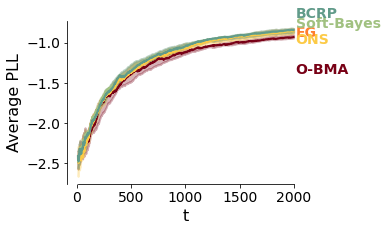

In [15]:
labels = ["EG", 'O-BMA', 'ONS', 'Soft-Bayes','BCRP',]
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3))
make_plot(np.arange(10, N), [reward_t_eg[:,10:], reward_t_bma[:, 10:],  reward_t_ons[:,10:], reward_t_softbayes[:,10:],reward_t_static[:,10:],], 
          labels, colors[:5], ax, offsets=[-0.025, -0.4, -0.1, 0.08, 0.2,])  # [-0.082, 0.059, 0.001, -0.049]
plt.xlabel('t')
plt.ylabel('Average PLL')

plt.savefig("BONG.pdf", bbox_inches="tight")

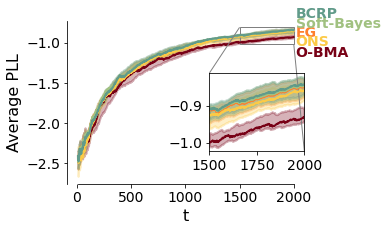

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Suppose these are your data arrays (replace with your actual data)
import numpy as np
N = 2000
labels = ["EG", "O-BMA", "ONS", "Soft-Bayes", "BCRP"]

# Main figure and axes
fig, ax = plt.subplots(figsize=(4.25, 3))

# Main plot
# reward_t_bma
# reward_t_ons
# reward_t_eg
# reward_t_softbayes
# reward_t_static
make_plot(
    np.arange(10, N-1),
    [
        reward_t_eg[:, 10:],
        reward_t_bma[:, 10:],
        reward_t_ons[:, 10:],
        reward_t_softbayes[:, 10:],
        reward_t_static[:, 10:]
    ],
    labels,
    colors,
    ax,
    offsets=[-0.03, -0.2, -0.135, 0.08, 0.2]
)

ax.set_xlabel("t")
ax.set_ylabel("Average PLL")

# Create the inset axes in the lower-right corner
# width="40%" and height="40%" is just an example sizing
ax_inset = inset_axes(
    ax,
    width="40%",
    height="40%",
    loc="lower right",    
    bbox_to_anchor=(0.0, 0.2, 1.0, 1.2),  
    bbox_transform=ax.transAxes,  # interpret bbox in ax's coordinate system
    borderpad=0
)

def make_inset_plot(x, y, colors, ax, linestyle="solid"):
    for i, label in enumerate(labels):
        y_mean = np.mean(y[i], axis=0)
        y_std = np.std(y[i], axis=0)

        ax.plot(
            x,
            np.quantile(y[i], 0.5, axis=0),
            color=colors[i],
            linewidth=2,
            linestyle=linestyle,
        )

        ax.fill_between(
            x,
            np.quantile(y[i], 0.1, axis=0),
            np.quantile(y[i], 0.9, axis=0),
            color=colors[i],
            linewidth=2,
            alpha=0.3,
        )

# Replot (or partially re-plot) only the region of interest in the inset
make_inset_plot(
    np.arange(1500, N-1),
    [
        reward_t_eg[:, 1500:],
        reward_t_bma[:, 1500:],
        reward_t_ons[:, 1500:],
        reward_t_softbayes[:, 1500:],
        reward_t_static[:, 1500:]
    ],
    colors,
    ax_inset
)
# Zoom in on t > 1500
ax_inset.set_xlim(1500, N)

# If you'd like to draw connecting lines highlighting the zoomed region:
mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")

plt.savefig("BONG.pdf", bbox_inches="tight")
plt.show()


In [17]:
M = log_ws_eg.shape[2]

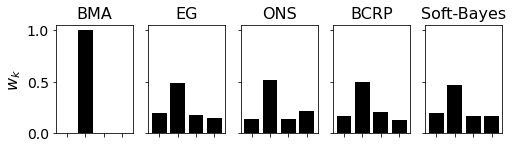

In [18]:
simu = 0
fig, axs = plt.subplots(1, 5, figsize=(8, 2), sharey=True)

axs[0].bar(range(M),np.exp(logws_bma)[simu,-1,:], color='black')
axs[0].set_xticks(range(M), [''] * M)
axs[0].set_title('BMA')
axs[0].set_ylabel('$w_k$')

axs[1].bar(range(M),np.exp(log_ws_eg)[simu,-1,:], color='black')
axs[1].set_xticks(range(M), [''] * M)
axs[1].set_title('EG')


axs[2].bar(range(M),ws_ons[simu,-1,:], color='black')
axs[2].set_xticks(range(M), [''] * M)
axs[2].set_title('ONS')

axs[3].bar(range(M),static_weights[simu,:], color='black')
axs[3].set_xticks(range(M), [''] * M)
axs[3].set_title('BCRP')

axs[4].bar(range(M),np.exp(logws_softbayes[simu,-1,:]), color='black')
axs[4].set_xticks(range(M), [''] * M)
axs[4].set_title('Soft-Bayes')

plt.savefig('weights_BONG_final.pdf', bbox_inches='tight')

In [19]:
colors_hist = ['#008000', '#808080', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#000000',
 '#FFFFFF', '#FFA500', '#800080', '#FF0000', '#00FF00', '#FFC0CB', '#800000', '#000080']


In [20]:
N = log_ws_eg.shape[1]
colors_hist = colors_hist[:J]

In [21]:
log_ws_eg.shape

(5, 1999, 4)

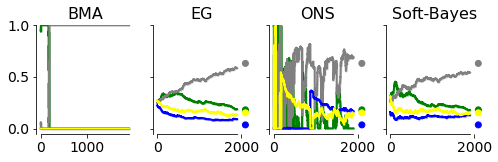

In [22]:
simu = 0
fig, axs = plt.subplots(1, 4, figsize=(8, 2), sharey=True)

make_plot(np.arange(N-100), [np.exp(logws_bma)[-1:, 100:, i] for i in range(M)], 
          [''] * M, colors_hist, axs[0], offsets=[0]*M, ylim=[-0.05, 1])
axs[0].set_title('BMA')

make_plot(np.arange(N-100), [np.exp(log_ws_eg)[-1:, 100:, i] for i in range(M)], 
          [''] * M, colors_hist, axs[1], offsets=[0]*M, ylim=None, ticks_y=None)
axs[1].set_title('EG')
axs[1].scatter([N + 100] * M, static_weights[-1, :], color=colors_hist)

make_plot(np.arange(N-100), [ws_ons[-1:, 100:-1, i] for i in range(M)], 
          [''] * M, colors_hist, axs[2], offsets=[0]*M, ylim=None, ticks_y=None)
axs[2].scatter([N + 100] * M, static_weights[-1, :], color=colors_hist)
axs[2].set_title('ONS')

make_plot(np.arange(N-100), [np.exp(logws_softbayes)[-1:, 100:, i] for i in range(M)], 
          [''] * M, colors_hist, axs[3], offsets=[0]*M, ylim=None, ticks_y=None)
axs[3].scatter([N + 100] * M, static_weights[-1, :], color=colors_hist)
axs[3].set_title('Soft-Bayes')

plt.savefig('weights_BONG_evolutions.pdf', bbox_inches='tight')



# Learning Rate Ablation

In [23]:

# Load the MNIST results

results = []
paths = ['../results/mnist_results/mlp/dlrg-l-ef-bong-R10_nlls_0.1.pkl',
         '../results/mnist_results/mlp/dlrg-l-ef-bong-R10_nlls_0.01.pkl',
         '../results/mnist_results/mlp/dlrg-l-ef-bong-R10_nlls_1.0.pkl',
         '../results/mnist_results/mlp/dlrg-l-ef-bong-R10_nlls_10.0.pkl']
for path in paths:
    with open(path, 'rb') as f:
        results.append(pickle.load(f))

results = np.concatenate(results, axis=0)
results.shape

(40, 2000, 2000)

In [24]:
#%%
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import lax, jit, value_and_grad
from functools import partial
import optax 
import numpy as np
from jax.scipy.special import logsumexp
from scipy.stats import norm

import argparse

import cvxopt
from cvxopt import matrix, solvers
cvxopt.solvers.options['show_progress'] = False


compute_ons = 1
N = 999

#%% Auxiliary functions
def get_weights_expgrad(alpha,pll_t):
    def _step_weights(carry, i):
            log_w = carry

            li = jnp.asarray(pll_t)[:,i-1]

            # Exponentiated Gradients
            log_w = log_w + alpha * jnp.exp(
                li - jax.scipy.special.logsumexp(log_w + li)
            )
            log_w = log_w - jax.scipy.special.logsumexp(log_w)

            return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0])/pll_t.shape[0])
    w = jnp.exp(logw)    
    final_log_w, log_ws = lax.scan(
            _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
        )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)  # we don't consider the last weight

    return log_ws


def get_weights_expgrad_bma(alpha,pll_t):
    def _step_weights(carry, i):
            log_w = carry

            li = jnp.asarray(pll_t)[:,i-1]

            # Exponentiated Gradients
            log_w = log_w + alpha * li
            log_w = log_w - jax.scipy.special.logsumexp(log_w)

            return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0])/pll_t.shape[0])
    w = jnp.exp(logw)    
    final_log_w, log_ws = lax.scan(
            _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
        )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws

def get_weights_dma(gamma, pll_t):
    def _step_weights_dma(log_w_prev_posterior, time_step_idx):
        log_w_predictive_unnormalized = gamma * log_w_prev_posterior
        log_w_curr_predictive = log_w_predictive_unnormalized - jax.scipy.special.logsumexp(log_w_predictive_unnormalized)

        current_log_likelihoods = jnp.asarray(pll_t)[:, time_step_idx - 1]

        log_w_curr_posterior_unnormalized = log_w_curr_predictive + current_log_likelihoods
        log_w_curr_posterior = log_w_curr_posterior_unnormalized - jax.scipy.special.logsumexp(log_w_curr_posterior_unnormalized)

        return log_w_curr_posterior, log_w_curr_predictive

    num_models = pll_t.shape[0]
    num_time_steps = pll_t.shape[1]

    initial_log_w_posterior = jnp.log(jnp.ones(num_models) / num_models)

    _final_log_w_posterior, log_ws_predictive_sequence = lax.scan(
        _step_weights_dma,
        initial_log_w_posterior,
        jnp.arange(1, num_time_steps + 1)
    )

    return log_ws_predictive_sequence

def get_weights_softbayes(alpha, pll_t):
    def _step_weights(carry, i):
            log_w = carry

            li = jnp.asarray(pll_t)[:,i-1]
            M_t = logsumexp(log_w + li)

            # Soft-Bayes
            log_w = log_w + logsumexp(jnp.array([jnp.log1p(-alpha), jnp.log(alpha) + (li - M_t)]))

            return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0])/pll_t.shape[0])
    w = jnp.exp(logw)    
    final_log_w, log_ws = lax.scan(
            _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
        )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws

def get_weights_corrected_softbayes(M, pll_t):
    log_M = jnp.log(M)

    def _step_weights(carry, i):
            alpha_t = jnp.sqrt(log_M / (2 * M * (i)))
            alpha_tp1 = jnp.sqrt(log_M / (2 * M * (i+1)))

            log_w = carry

            li = jnp.asarray(pll_t)[:,i-1]
            M_t = logsumexp(log_w + li)

            # Soft-Bayes
            A = log_w 
            B = jnp.log(1 - alpha_t + alpha_t * jnp.exp(li - M_t))# logsumexp(jnp.array([jnp.log1p(-alpha_t) * jnp.ones(pll_t.shape[0]), jnp.log(alpha_t) + (li - M_t)]))
            C = jnp.log(alpha_tp1 / alpha_t) * jnp.ones(pll_t.shape[0])
            D = jnp.log(1 - alpha_tp1 / alpha_t) + jnp.ones(pll_t.shape[0]) * jnp.log(1/M)
            # print(A.shape, B.shape, C.shape, D.shape)
            # print((A + B + C).shape)
            # print(D.shape)
            log_w = logsumexp(jnp.array([A + B + C, D]), axis=0)   
            # print(carry.shape, log_w.shape)

            return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0])/pll_t.shape[0])
    w = jnp.exp(logw)    
    final_log_w, log_ws = lax.scan(
            _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
        )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws

def get_static_weights(pll_t): # best constant rebalanced portfolio (BCRP)

    def neg_log_wealth(log_weights,pll_t):   # log_weights are not normalized!
        log_mix = logsumexp(log_weights + pll_t.T - logsumexp(log_weights),axis=1)

        return -jnp.sum(log_mix)
    
    neg_log_wealth_jit = jit(neg_log_wealth)

    init_params = jnp.log(jnp.ones(pll_t.shape[0]) \
                        + 0.3*jax.random.normal(jax.random.PRNGKey(my_seed+20),(pll_t.shape[0],))
                        )


    # Define the optimizer
    optimizer = optax.adam(learning_rate=0.01)
    opt_state = optimizer.init(init_params)

    # Define the update step
    @partial(jax.jit)
    def update(params, opt_state, pll_t):
        loss, grads = value_and_grad(neg_log_wealth_jit)(params,pll_t)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    # Training loop
    params = init_params
    num_steps = 1000
    loss_vals = []
    for step in range(num_steps):
        loss, params, opt_state = update(params, opt_state, pll_t)
        loss_vals.append(loss)

    static_weights = jnp.exp(params - logsumexp(params))

    return static_weights


# Modified from the Universal Portfolios library 
# https://github.com/Marigold/universal-portfolios/blob/master/universal/algos/ons.py
# Available under MIT License
class ONS:
    def __init__(self, delta=1/8, beta=1e-5, eta=0.0):
        """
        :param delta, beta, eta: Model parameters. See paper.
        """
        super().__init__()
        self.delta = delta
        self.beta = beta
        self.eta = eta

    def init_weights(self, m):
        self.A = np.mat(np.eye(m))
        self.b = np.mat(np.zeros(m)).T

        return np.ones(m) / m
        
    def step(self, r, p):
        # calculate gradient
        grad = np.mat(r / np.dot(p, r)).T
        # update A
        self.A += grad * grad.T
        # update b
        self.b += (1 + 1.0 / self.beta) * grad

        # projection of p induced by norm A
        pp = self.projection_in_norm(self.delta * self.A.I * self.b, self.A)
        return pp * (1 - self.eta) + np.ones(len(r)) / float(len(r)) * self.eta

    def projection_in_norm(self, x, M):
        """Projection of x to simplex indiced by matrix M. Uses quadratic programming."""
        m = M.shape[0]

        P = matrix(2 * M)
        q = matrix(-2 * M * x)
        G = matrix(-np.eye(m))
        h = matrix(np.zeros((m, 1)))
        A = matrix(np.ones((1, m)))
        b = matrix(1.0)

        sol = solvers.qp(P, q, G, h, A, b)
        return np.squeeze(sol["x"])
    
def get_weights_ons(delta,beta,eta, pll_t):
    reward_t = np.exp(pll_t)
    max_reward_t = reward_t.max(0, keepdims=True)
    reward_t_norm = reward_t /max_reward_t

    ons = ONS(delta, beta, eta)
    current_weights = ons.init_weights(pll_t.shape[0])
    all_weights = [current_weights]

    for current_reward in reward_t_norm.T:
        try:
            current_weights = ons.step(current_reward, current_weights)
            all_weights.append(current_weights)
        except:
            print(current_reward)
            print(current_weights)
            raise Exception("Error in ONS")

    all_weights = np.maximum(np.stack(all_weights), np.zeros_like(np.stack(all_weights))+1e-64)

    return all_weights    


#%% Generating the data
J = 4

for my_seed in range(10):
    #pll_t = -np.mean(results, axis=-1)#
    pll_t = -np.array(jax.vmap(lambda x: jnp.diag(x, k=1))(results[my_seed::10]))
    # Get shape of array
    J, N = pll_t.shape

    # Find NaN values
    nan_mask = np.isnan(pll_t)

    # For each row with NaNs, replace with mean of neighboring columns
    for i in range(J):
        nan_idx = np.where(nan_mask[i])[0]
        for idx in nan_idx:
            # Get window of 10 values on each side, excluding NaNs
            window_start = max(0, idx-10)
            window_end = min(N, idx+11)
            window = pll_t[i, window_start:window_end]
            window = window[~np.isnan(window)]
            
            # Replace NaN with mean of window
            if len(window) > 0:
                pll_t[i, idx] = np.mean(window)

    rewards = {}
    weights = {}

    # computing the weights
    logws_egm0 = get_weights_expgrad(1e-0, pll_t)
    weights["egm0"] = logws_egm0

    logws_egm2 = get_weights_expgrad(1e-2, pll_t)
    weights["egm2"] = logws_egm2

    # computing the weights
    logws_egm3 = get_weights_expgrad(1e-3, pll_t)
    weights["egm3"] = logws_egm3

    # computing the weights
    logws_egm4 = get_weights_expgrad(1e-4, pll_t)
    weights["egm4"] = logws_egm4

    # computing the weights
    logws_egm1 = get_weights_expgrad(1e-1, pll_t)
    weights["egm1"] = logws_egm1

    logws_bma = get_weights_expgrad_bma(1, pll_t)
    weights["bma"] = logws_bma

    logws_bma_08 = get_weights_expgrad_bma(0.8, pll_t)
    weights["bma_08"] = logws_bma_08

    logws_bma_01 = get_weights_expgrad_bma(0.1, pll_t)
    weights["bma_01"] = logws_bma_01

    logws_dma = get_weights_dma(0.99, pll_t)
    weights["dma"] = logws_dma
    static_weights = get_static_weights(pll_t)
    weights["static"] = static_weights

    logws_softbayes = get_weights_corrected_softbayes(J, pll_t)
    weights["softbayes"] = logws_softbayes



    # computing rewards
    reward_t_egm1 = np.cumsum(logsumexp(pll_t.T + logws_egm1, axis=1))/ \
        np.arange(1,N+1)
    rewards["egm1"] = reward_t_egm1

    reward_t_egm2 = np.cumsum(logsumexp(pll_t.T + logws_egm2, axis=1))/ \
        np.arange(1,N+1)
    rewards["egm2"] = reward_t_egm2

    reward_t_egm3 = np.cumsum(logsumexp(pll_t.T + logws_egm3, axis=1))/ \
        np.arange(1,N+1)
    rewards["egm3"] = reward_t_egm3

    reward_t_egm4 = np.cumsum(logsumexp(pll_t.T + logws_egm4, axis=1))/ \
        np.arange(1,N+1)
    rewards["egm4"] = reward_t_egm4

    reward_t_egm0 = np.cumsum(logsumexp(pll_t.T + logws_egm0, axis=1))/ \
        np.arange(1,N+1)
    rewards["egm5"] = reward_t_egm0

    reward_t_bma =  np.cumsum(logsumexp(pll_t.T + logws_bma, axis=1))/ \
        np.arange(1,N+1)
    rewards["bma"] = reward_t_bma

    reward_t_bma_08 =  np.cumsum(logsumexp(pll_t.T + logws_bma_08, axis=1))/ \
        np.arange(1,N+1)
    rewards["bma_08"] = reward_t_bma_08

    reward_t_bma_01 =  np.cumsum(logsumexp(pll_t.T + logws_bma_01, axis=1))/ \
        np.arange(1,N+1)
    rewards["bma_01"] = reward_t_bma_01

    reward_t_dma =  np.cumsum(logsumexp(pll_t.T + logws_dma, axis=1))/ \
        np.arange(1,N+1)
    rewards["dma"] = reward_t_dma

    reward_t_static = np.cumsum(logsumexp(pll_t.T + np.log(static_weights), axis=1))/  \
        np.arange(1, N+1)
    rewards["static"] = reward_t_static

    reward_t_softbayes = np.cumsum(logsumexp(pll_t.T + logws_softbayes, axis=1))/ \
        np.arange(1, N+1)
    rewards["softbayes"] = reward_t_softbayes

    # normalizing the rewards (exponentiated log predictive values)
    ws_ons_m4 = get_weights_ons(0.8,1e-4,0.01, pll_t)
    weights["ons_m4"] = ws_ons_m4
    ws_ons_m3 = get_weights_ons(0.8,1e-3,0.01, pll_t)
    weights["ons_m3"] = ws_ons_m3
    ws_ons_m2 = get_weights_ons(0.8,1e-2,0.01, pll_t)
    weights["ons_m2"] = ws_ons_m2
    ws_ons_m1 = get_weights_ons(0.8,1e-1,0.01, pll_t)
    weights["ons_m1"] = ws_ons_m1
    ws_ons_m0 = get_weights_ons(0.8,1,0.01, pll_t)
    weights["ons_m0"] = ws_ons_m0

    reward_t_ons_m4 =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons_m4[:-1]), axis=1))/ \
        np.arange(1,N+1)
    rewards["ons_m4"] = reward_t_ons_m4
    reward_t_ons_m3 =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons_m3[:-1]), axis=1))/ \
        np.arange(1,N+1)
    rewards["ons_m3"] = reward_t_ons_m3
    reward_t_ons_m2 =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons_m2[:-1]), axis=1))/ \
        np.arange(1,N+1)
    rewards["ons_m2"] = reward_t_ons_m2
    reward_t_ons_m1 =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons_m1[:-1]), axis=1))/ \
        np.arange(1,N+1)
    rewards["ons_m1"] = reward_t_ons_m1
    reward_t_ons_m0 =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons_m0[:-1]), axis=1))/ \
        np.arange(1,N+1)
    rewards["ons_m0"] = reward_t_ons_m0

    np.savez(f'results_setting_mnist_seed_{my_seed}_no_ons_lr_ablation.npz', logws_egm0, reward_t_egm0, logws_egm1, reward_t_egm1, logws_egm2, reward_t_egm2, logws_egm3, reward_t_egm3, logws_egm4, reward_t_egm4, logws_bma, logws_bma_08, logws_bma_01, reward_t_bma, reward_t_bma_08, reward_t_bma_01, static_weights, reward_t_static, logws_softbayes, reward_t_softbayes, ws_ons_m4, reward_t_ons_m4, ws_ons_m3, reward_t_ons_m3, ws_ons_m2, reward_t_ons_m2, ws_ons_m1, reward_t_ons_m1, ws_ons_m0, reward_t_ons_m0, logws_dma, reward_t_dma)



In [25]:
logws_egm0_s = []
reward_t_egm0_s = []
logws_egm1_s = []
reward_t_egm1_s = []
logws_egm2_s = []
reward_t_egm2_s = []
logws_egm3_s = []
reward_t_egm3_s = []
logws_egm4_s = []
reward_t_egm4_s = []
logws_bma_s = []
logws_bma_08_s = []
logws_bma_01_s = []
reward_t_bma_s = []
reward_t_bma_08_s = []
reward_t_bma_01_s = []
static_weights_s = []
reward_t_statics = []
logws_softbayes_s = []
reward_t_softbayes_s = []
logws_ons_m4_s = []
reward_t_ons_m4_s = []
logws_ons_m3_s = []
reward_t_ons_m3_s = []
logws_ons_m2_s = []
reward_t_ons_m2_s = []
logws_ons_m1_s = []
reward_t_ons_m1_s = []
logws_ons_m0_s = []
reward_t_ons_m0_s = []
logws_dma_s = []
reward_t_dma_s = []



for seed in range(5):
    results = np.load(f'results_setting_mnist_seed_{seed}_no_ons_lr_ablation.npz')
    logws_egm0_s.append(results['arr_0'])   
    reward_t_egm0_s.append(results['arr_1'])
    logws_egm1_s.append(results['arr_2'])
    reward_t_egm1_s.append(results['arr_3'])
    logws_egm2_s.append(results['arr_4'])
    reward_t_egm2_s.append(results['arr_5'])
    logws_egm3_s.append(results['arr_6']) 
    reward_t_egm3_s.append(results['arr_7'])
    logws_egm4_s.append(results['arr_8'])
    reward_t_egm4_s.append(results['arr_9'])
    logws_bma_s.append(results['arr_10'])
    logws_bma_08_s.append(results['arr_11'])
    logws_bma_01_s.append(results['arr_12'])
    reward_t_bma_s.append(results['arr_13'])
    reward_t_bma_08_s.append(results['arr_14'])
    reward_t_bma_01_s.append(results['arr_15'])
    static_weights_s.append(results['arr_16'])
    reward_t_statics.append(results['arr_17'])
    logws_softbayes_s.append(results['arr_18'])
    reward_t_softbayes_s.append(results['arr_19'])
    logws_ons_m4_s.append(results['arr_20'])
    reward_t_ons_m4_s.append(results['arr_21'])
    logws_ons_m3_s.append(results['arr_22'])
    reward_t_ons_m3_s.append(results['arr_23'])
    logws_ons_m2_s.append(results['arr_24'])
    reward_t_ons_m2_s.append(results['arr_25'])
    logws_ons_m1_s.append(results['arr_26'])
    reward_t_ons_m1_s.append(results['arr_27'])
    logws_ons_m0_s.append(results['arr_28'])
    reward_t_ons_m0_s.append(results['arr_29'])
    logws_dma_s.append(results['arr_30'])
    reward_t_dma_s.append(results['arr_31'])

log_ws_egm0 = np.stack(logws_egm0_s)
reward_t_egm0 = np.stack(reward_t_egm0_s)
log_ws_egm1 = np.stack(logws_egm1_s)
reward_t_egm1 = np.stack(reward_t_egm1_s)
log_ws_egm2 = np.stack(logws_egm2_s)
reward_t_egm2 = np.stack(reward_t_egm2_s)
log_ws_egm3 = np.stack(logws_egm3_s)
reward_t_egm3 = np.stack(reward_t_egm3_s)
log_ws_egm4 = np.stack(logws_egm4_s)
reward_t_egm4 = np.stack(reward_t_egm4_s)
logws_bma = np.stack(logws_bma_s)
logws_bma_08 = np.stack(logws_bma_08_s)
logws_bma_01 = np.stack(logws_bma_01_s)
reward_t_bma = np.stack(reward_t_bma_s)
reward_t_bma_08 = np.stack(reward_t_bma_08_s)
reward_t_bma_01 = np.stack(reward_t_bma_01_s)
static_weights = np.stack(static_weights_s)
reward_t_static = np.stack(reward_t_statics)
logws_softbayes = np.stack(logws_softbayes_s)
reward_t_softbayes = np.stack(reward_t_softbayes_s)
logws_ons_m4 = np.stack(logws_ons_m4_s)
reward_t_ons_m4 = np.stack(reward_t_ons_m4_s)
logws_ons_m3 = np.stack(logws_ons_m3_s)
reward_t_ons_m3 = np.stack(reward_t_ons_m3_s)
logws_ons_m2 = np.stack(logws_ons_m2_s)
reward_t_ons_m2 = np.stack(reward_t_ons_m2_s)
logws_ons_m1 = np.stack(logws_ons_m1_s)
reward_t_ons_m1 = np.stack(reward_t_ons_m1_s)
logws_ons_m0 = np.stack(logws_ons_m0_s)
reward_t_ons_m0 = np.stack(reward_t_ons_m0_s)
logws_dma = np.stack(logws_dma_s)
reward_t_dma = np.stack(reward_t_dma_s)


In [26]:
print(reward_t_egm1.shape)

(5, 1999)


In [27]:
colors = ["#FE7F2D", "#780116","#FCCA46",  "#A1C181", "#619B8A", "#1D4EFC", "#0B3D91", "#C1007E", "#00D4FF", "#8C00FF"]
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", weight="normal") 
plt.rc("font", size=SIZE_DEFAULT) 
plt.rc("axes", titlesize=SIZE_LARGE) 
plt.rc("axes", labelsize=SIZE_LARGE) 
plt.rc("xtick", labelsize=SIZE_DEFAULT) 
plt.rc("ytick", labelsize=SIZE_DEFAULT) 

def make_plot(
    x, y, labels, colors, ax, linestyle="solid", offsets=None, ylim=None, ticks_y=True
):
    if offsets is None:
        offsets = [
            0.0,
        ] * len(labels)

    # Plot each of the main lines
    for i, label in enumerate(labels):
        y_mean = np.mean(y[i], axis=0)
        y_std = np.std(y[i], axis=0)

        ax.plot(
            x,
            np.quantile(y[i], 0.5, axis=0),
            label=label,
            color=colors[i],
            linewidth=2,
            linestyle=linestyle,
        )

        # for q, alpha in zip([0.10, 0.25, 0.45], [0.5, 0.4, 0.3]):
        #     ax.fill_between(
        #         x,
        #         np.quantile(y[i], 0.5 - q, axis=0),
        #         np.quantile(y[i], 0.5 + q, axis=0),
        #         color=colors[i],
        #         linewidth=2,
        #         alpha=alpha,
        #     )

        ax.fill_between(
            x,
            np.quantile(y[i], 0.1, axis=0),
            np.quantile(y[i], 0.9, axis=0),
            color=colors[i],
            linewidth=2,
            alpha=0.3,
        )

        ax.text(
            x[-1] * 1.01,
            np.median(y[i], axis=0)[-1] + offsets[i],
            label,
            color=colors[i],
            fontweight="bold",
            horizontalalignment="left",
            verticalalignment="center",
        )

    # Hide the all but the bottom spines (axis lines)
    ax.spines["right"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Only show ticks on the left and bottom spines
    if ticks_y:
        ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.spines["bottom"].set_bounds(min(x), max(x))
    if ylim:
        ax.set_ylim(ylim)


In [ ]:
# Get median values
values = {
    'reward_t_egm1': np.median(reward_t_egm1, axis=0)[-1],
    'reward_t_egm2': np.median(reward_t_egm2, axis=0)[-1], 
    'reward_t_egm3': np.median(reward_t_egm3, axis=0)[-1],
    'reward_t_egm4': np.median(reward_t_egm4, axis=0)[-1],
    'reward_t_bma': np.median(reward_t_bma, axis=0)[-1], 
    'reward_t_bma_08': np.median(reward_t_bma_08, axis=0)[-1],
    'reward_t_bma_01': np.median(reward_t_bma_01, axis=0)[-1],
    'reward_t_static': np.median(reward_t_static, axis=0)[-1],
    'reward_t_softbayes': np.median(reward_t_softbayes, axis=0)[-1],
    'reward_t_dma': np.median(reward_t_dma, axis=0)[-1],
}

# Sort by value and print variable names in order
sorted_vars = sorted(values.items(), key=lambda x: x[1])
for var_name, _ in sorted_vars:
    print(var_name)


reward_t_bma
reward_t_bma_08
reward_t_dma
reward_t_bma_01
reward_t_egm4
reward_t_egm3
reward_t_egm1
reward_t_egm2
reward_t_softbayes
reward_t_static


Text(0, 0.5, 'Average PLL')

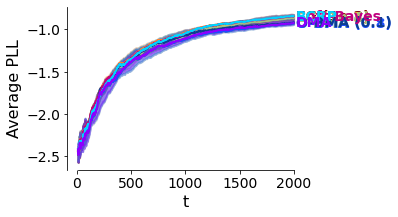

In [29]:
labels = ["EG (1e-1)", 'EG (1e-2)', 'EG (1e-3)', 'EG (1e-4)', 'O-BMA', "O-BMA (0.8)", "O-BMA (0.1)", 'Soft-Bayes','BCRP', 'DMA']
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3))
make_plot(np.arange(10, N), [reward_t_egm1[:,10:], reward_t_egm2[:, 10:],  reward_t_egm3[:,10:], reward_t_egm4[:,10:],reward_t_bma[:,10:], reward_t_bma_08[:,10:], reward_t_bma_01[:,10:], reward_t_softbayes[:,10:],reward_t_static[:,10:],reward_t_dma[:,10:]], 
          labels, colors, ax,)# offsets=[-0.025, -0.4, -0.1, 0.08, 0.2,])  # [-0.082, 0.059, 0.001, -0.049]
plt.xlabel('t')
plt.ylabel('Average PLL')

# plt.savefig("BONG.pdf", bbox_inches="tight")

In [30]:
labels = ["EG (1e0)", "EG (1e-1)", 'EG (1e-2)', 'EG (1e-3)', 'EG (1e-4)', 'O-BMA',  "O-BMA (0.8)", "O-BMA (0.1)", 'Soft-Bayes','BCRP', "ON (1e-4)", "ON (1e-3)", "ON (1e-2)", "ON (1e-1)", "ON (1e0)", 'DMA']
rewards = [reward_t_egm0[:,10:], reward_t_egm1[:,10:], reward_t_egm2[:, 10:],  reward_t_egm3[:,10:], reward_t_egm4[:,10:],reward_t_bma[:,10:], reward_t_bma_08[:,10:], reward_t_bma_01[:,10:], reward_t_softbayes[:,10:],reward_t_static[:,10:],reward_t_ons_m4[:,10:], reward_t_ons_m3[:,10:], reward_t_ons_m2[:,10:], reward_t_ons_m1[:,10:], reward_t_ons_m0[:, 10:], reward_t_dma[:,10:]]


In [ ]:
for i, label_and_result in enumerate(zip(labels, rewards)):
    label, rewards = label_and_result
    print(f"{label} {np.median(rewards[:, -1]):.3f} {np.std(rewards[:, -1]):.2f}")

EG (1e0) -1.012 0.04
EG (1e-1) -0.850 0.02
EG (1e-2) -0.850 0.02
EG (1e-3) -0.862 0.02
EG (1e-4) -0.865 0.02
O-BMA -0.932 0.02
O-BMA (0.8) -0.930 0.02
O-BMA (0.1) -0.920 0.02
Soft-Bayes -0.847 0.02
BCRP -0.843 0.02
ON (1e-4) -0.948 0.03
ON (1e-3) -0.900 0.03
ON (1e-2) -0.860 0.02
ON (1e-1) -0.859 0.03
ON (1e0) -0.878 0.03
DMA -0.925 0.02


In [32]:
rewards

array([[-2.42084591, -2.47931453, -2.44908463, ..., -0.90707498,
        -0.90663717, -0.90620512],
       [-2.48919932, -2.49339489, -2.48198839, ..., -0.93999898,
        -0.9395814 , -0.93958895],
       [-2.37587839, -2.32874229, -2.34133425, ..., -0.88775919,
        -0.88762565, -0.88751777],
       [-2.40398484, -2.37902908, -2.36965275, ..., -0.92668579,
        -0.92622201, -0.92715708],
       [-2.6108259 , -2.6280964 , -2.62502299, ..., -0.92599451,
        -0.92553118, -0.92506831]])

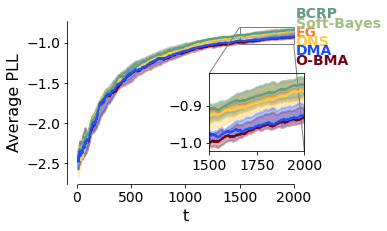

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Suppose these are your data arrays (replace with your actual data)
import numpy as np
N = 2000
labels = ["EG", "O-BMA", "ONS", "Soft-Bayes", "BCRP", "DMA"]

# Main figure and axes
fig, ax = plt.subplots(figsize=(4.25, 3))

# Main plot
# reward_t_bma
# reward_t_ons
# reward_t_eg
# reward_t_softbayes
# reward_t_static
make_plot(
    np.arange(10, N-1),
    [
        reward_t_eg[:, 10:],
        reward_t_bma[:, 10:],
        reward_t_ons[:, 10:],
        reward_t_softbayes[:, 10:],
        reward_t_static[:, 10:],
        reward_t_dma[:, 10:]
    ],
    labels,
    colors,
    ax,
    offsets=[-0.03, -0.3, -0.135, 0.08, 0.2, -0.18]
)

ax.set_xlabel("t")
ax.set_ylabel("Average PLL")

# Create the inset axes in the lower-right corner
# width="40%" and height="40%" is just an example sizing
ax_inset = inset_axes(
    ax,
    width="40%",
    height="40%",
    loc="lower right",    
    bbox_to_anchor=(0.0, 0.2, 1.0, 1.2),  
    bbox_transform=ax.transAxes,  # interpret bbox in ax's coordinate system
    borderpad=0
)

def make_inset_plot(x, y, colors, ax, linestyle="solid"):
    for i, label in enumerate(labels):
        y_mean = np.mean(y[i], axis=0)
        y_std = np.std(y[i], axis=0)

        ax.plot(
            x,
            np.quantile(y[i], 0.5, axis=0),
            color=colors[i],
            linewidth=2,
            linestyle=linestyle,
        )

        ax.fill_between(
            x,
            np.quantile(y[i], 0.1, axis=0),
            np.quantile(y[i], 0.9, axis=0),
            color=colors[i],
            linewidth=2,
            alpha=0.3,
        )

# Replot (or partially re-plot) only the region of interest in the inset
make_inset_plot(
    np.arange(1500, N-1),
    [
        reward_t_eg[:, 1500:],
        reward_t_bma[:, 1500:],
        reward_t_ons[:, 1500:],
        reward_t_softbayes[:, 1500:],
        reward_t_static[:, 1500:],
        reward_t_dma[:, 1500:]
    ],
    colors,
    ax_inset
)
# Zoom in on t > 1500
ax_inset.set_xlim(1500, N)

# If you'd like to draw connecting lines highlighting the zoomed region:
mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")

plt.savefig("BONG_with_DMA.pdf", bbox_inches="tight")
plt.show()
